In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import gym


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [40]:
from gym import spaces, logger
from gym.envs.classic_control import rendering

class RacingEnv(gym.Env):
    def __init__(self, seed):
        np.random.seed(seed)
        
        self.viewer = None
        
        self.action_space = spaces.Box(low = -1.0, high = 1.0, shape = (2,), dtype = np.float32)
        self.observation_space = spaces.Box(low = -1.0, high = 1.0, shape = (6,), dtype=np.float32)
        global state_size
        state_size = self.observation_space.shape[0]
        global action_size
        action_size = self.action_space.shape[0]
        
        self.maxSpeed = 50
        self.accel = 0.05
        self.turnRate = 2.0
        self.minTurnRadius = 75
        
        self.make_track()
        self.reset()
    
    def translate(self, v, angle, dist):
        angle = angle / 180 * np.pi
        x, y = v
        x += np.cos(angle) * dist
        y += np.sin(angle) * dist
        return x, y
    
    def make_track(self):
        v = (0, 0)
        self.lwall = [(-100, -10)]
        self.rwall = [(100, -10)]
        angle = 90
        for i in range(50):
            angle += (np.random.rand() - 0.5) * 75
            v = self.translate(v, angle, 200)
            self.lwall.append(self.translate(v, angle + 90, 100))
            self.rwall.append(self.translate(v, angle - 90, 100))
    
    def magnitude(self, vector):
        return np.sqrt(np.dot(np.array(vector),np.array(vector)))

    def norm(self, vector):
        return np.array(vector)/self.magnitude(np.array(vector))
    
    def lineRayIntersectionDist(self, origin, direction, dist, point1, point2):
        rayOrigin = np.array(origin, dtype=np.float)
        rayDirection = np.array(self.norm(self.translate((0, 0), direction, 1)), dtype=np.float)
        point1 = np.array(point1, dtype=np.float)
        point2 = np.array(point2, dtype=np.float)
        v1 = rayOrigin - point1
        v2 = point2 - point1
        v3 = np.array([-rayDirection[1], rayDirection[0]])
        t1 = np.cross(v2, v1) / np.dot(v2, v3)
        t2 = np.dot(v1, v3) / np.dot(v2, v3)
        if t1 < 0.0 or t1 > dist or t2 < 0.0 or t2 > 1.0:
            return dist
        return t1
    
    def rayDist(self, direction):
        dist = 500
        d = dist
        for i in range(self.checkpoint, len(self.lwall) - 1):
            v0 = self.lwall[i]
            v1 = self.lwall[i + 1]
            d = self.lineRayIntersectionDist([self.x, self.y], direction, dist, v0, v1)
            if d < dist:
                break
            
            v0 = self.rwall[i]
            v1 = self.rwall[i + 1]
            d = self.lineRayIntersectionDist([self.x, self.y], direction, dist, v0, v1)
            if d < dist:
                break
        return d
    
    def getCheckpoint(self, i):
        if i < 0: i = 0
        return [self.lwall[i], self.lwall[i + 1], self.rwall[i + 1], self.rwall[i]]
    
    def pointInsidePolygon(self, x,y,poly):
        n = len(poly)
        inside =False
        p1x,p1y = poly[0]
        for i in range(n+1):
            p2x,p2y = poly[i % n]
            if y > min(p1y,p2y):
                if y <= max(p1y,p2y):
                    if x <= max(p1x,p2x):
                        if p1y != p2y:
                            xinters = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                        if p1x == p2x or x <= xinters:
                            inside = not inside
            p1x,p1y = p2x,p2y
        return inside
    
    def midpoint(self, p):
        x = (p[0][0] + p[1][0] + p[2][0] + p[3][0]) / 4
        y = (p[0][1] + p[1][1] + p[2][1] + p[3][1]) / 4
        return x, y
    
    def checkpointAngle(self, i):
        c0 = self.midpoint(self.getCheckpoint(i))
        c1 = self.midpoint(self.getCheckpoint(i + 1))
        xdiff = c1[0] - c0[0]
        ydiff = c1[1] - c0[1]
        return np.arctan2(ydiff, xdiff)
    
    def step(self, action):
        assert self.action_space.contains(action)
        
        self.forward = action[0]
        self.steer = action[1]
        
        targetSpeed = (self.forward / 2 + 0.5) * self.maxSpeed
        self.speed += (targetSpeed - self.speed) * self.accel
        self.angle -= self.steer * self.speed / (max(self.speed * self.speed / self.turnRate, self.minTurnRadius) * 2 * np.pi) * 2 * np.pi
        self.x += np.sin(self.angle) * self.speed
        self.y += np.cos(self.angle) * self.speed
        
        reward = self.speed / self.maxSpeed
        
        insideCurrent = self.pointInsidePolygon(self.x, self.y, self.getCheckpoint(self.checkpoint))
        if not insideCurrent:
            insideNext = self.pointInsidePolygon(self.x, self.y, self.getCheckpoint(self.checkpoint + 1))
            if insideNext:
                self.checkpoint = self.checkpoint + 1
            else:
                if self.checkpoint > 0: self.checkpoint -= 1
                self.x, self.y = self.midpoint(self.getCheckpoint(self.checkpoint))
                self.angle = -self.checkpointAngle(self.checkpoint) + np.pi / 2
                self.speed = 0
                reward -= 10
        
        self.t += 1
        done = False
        if self.t >= 200:
            done = True
        
        return np.array(self.get_state()), reward, done, {}
    
    def get_state(self):
        s = []
        for i in range(-2, 3):
            direction = i * 45 / 2 + 90 - self.angle * 180 / np.pi
            s.append(self.rayDist(direction) / 500)
        s.append(self.speed / self.maxSpeed)
        return s
    
    def reset(self):
        self.x = np.random.rand() - 0.5
        self.y = np.random.rand() - 0.5
        self.speed = 0
        self.angle = (np.random.rand() - 0.5) * 10 / 180 * np.pi
        
        self.t = 0
        
        self.checkpoint = 0
        
        return self.get_state()
    
    def render(self):
        time.sleep(1.0 / 60)
        
        if self.viewer == None:
            self.viewer = rendering.Viewer(1280, 720)
            
            car = rendering.FilledPolygon([(-20, -30), (-20, 30), (20, 30), (20, -30)])
            self.transform_translation = rendering.Transform()
            self.transform_rotation = rendering.Transform()
            self.transform_rotation.set_translation(640, 360)
            car.add_attr(self.transform_rotation)
            car.set_color(255, 0, 0)
            self.viewer.add_geom(car)
            
            lwall = rendering.PolyLine(self.lwall, False)
            lwall.add_attr(self.transform_translation)
            self.viewer.add_geom(lwall)
            rwall = rendering.PolyLine(self.rwall, False)
            rwall.add_attr(self.transform_translation)
            self.viewer.add_geom(rwall)
        
        self.transform_translation.set_translation(-self.x + 640, -self.y + 360)
        self.transform_rotation.set_rotation(-self.angle)
        
        for i in range(-2, 3):
            direction = i * 45 / 2 + 90 - self.angle * 180 / np.pi
            d = self.rayDist(direction)
            p = self.translate((640, 360), direction, d)
            self.viewer.draw_line([640, 360], p)
        
        self.viewer.draw_line((100, 100), (100, 100 + (self.forward + 1) * 50))
        self.viewer.draw_line((90, 100 + self.speed / self.maxSpeed * 100), (110, 100 + self.speed / self.maxSpeed * 100))
        self.viewer.draw_line((100, 100), (100 - self.steer * 50, 100))
        
        return self.viewer.render()
    
    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

In [3]:
tf.reset_default_graph()

class VanillaPG:
    def __init__(self):
        self.lr_critic = 0.0005
        self.lr_actor = 0.01
        self.entropy_factor = 0.02
        self.val_epochs = 50
        self.pol_epochs = 1
        self.minibatch_size = 200
        
        self.state = tf.placeholder("float", [None, state_size])
        self.action = tf.placeholder("float", [None, action_size])
        self.vl1 = tf.layers.dense(self.state, 100, activation = 'tanh')
        self.vl2 = tf.layers.dense(self.vl1, 100, activation = 'tanh')
        self.value = tf.layers.dense(self.vl2, 1, None)
        
        self.discounted_reward = tf.placeholder("float", [None, 1])
        self.vadvantage = self.discounted_reward - self.value
        self.vloss = tf.reduce_mean(tf.math.square(self.vadvantage))
        self.voptimizer = tf.train.AdamOptimizer(self.lr_critic).minimize(self.vloss)
        
        self.phidden = tf.layers.dense(self.state, 100)
        self.mu = tf.layers.dense(self.phidden, action_size, tf.nn.tanh)
        self.sigma = tf.layers.dense(self.phidden, action_size, tf.nn.softplus)
        self.normal_dist = tfp.distributions.Normal(self.mu, self.sigma)
        self.entropy = self.normal_dist.entropy()
        self.output = tf.clip_by_value(tf.squeeze(self.normal_dist.sample(1), axis = 0), -1.0, 1.0)

        self.target_action = tf.placeholder("float", [None, action_size])
        self.log_prob = self.normal_dist.log_prob(self.target_action)
        self.padvantage = tf.placeholder("float", [None, 1])
        self.ploss = -tf.reduce_mean(self.log_prob * self.padvantage + self.entropy * self.entropy_factor)
        self.poptimizer = tf.train.AdamOptimizer(self.lr_actor).minimize(self.ploss)
    
    def get_advantages(self, states, actions, discounted_rewards):
        return sess.run(self.vadvantage, feed_dict = {self.state: states, self.action: actions, self.discounted_reward: discounted_rewards})
    
    def update_val(self, states, actions, discounted_rewards):
        tloss = 0
        for _ in range(self.val_epochs):
            ids = np.random.randint(0, len(states), self.minibatch_size)
            feed_dict = {self.state: [states[i] for i in ids], self.action: [actions[i] for i in ids], self.discounted_reward: [discounted_rewards[i] for i in ids]}
            _, loss = sess.run([self.voptimizer, self.vloss], feed_dict = feed_dict)
            tloss += loss
        return tloss / self.val_epochs
    
    def get_action(self, state):
        return sess.run(self.output, feed_dict = {self.state: [state]})[0]
    
    def update_pol(self, states, actions, advantages, total_reward):
        tloss = 0
        for _ in range(self.pol_epochs):
            ids = np.random.randint(0, len(states), self.minibatch_size)
            feed_dict = {self.state: [states[i] for i in ids], self.target_action: [actions[i] for i in ids], self.padvantage: [advantages[i] for i in ids]}
            _, loss = sess.run([self.poptimizer, self.ploss], feed_dict = feed_dict)
            tloss += loss
        return tloss / self.pol_epochs

In [120]:
class SPG:
    def __init__(self):
        tf.reset_default_graph()
        
        self.lr_critic = 0.0005
        self.lr_actor = 0.001
        self.entropy_factor = 0.0
        self.samples = 5
        self.temp_initial = 1.0
        self.temp_decay = 0.01
        self.val_epochs = 50
        self.pol_epochs = 10
        self.minibatch_size = 200
        
        self.state = tf.placeholder("float", [None, state_size])
        self.action = tf.placeholder("float", [None, action_size])
        
        self.stateaction = tf.concat([self.state, self.action], axis = 1)
        self.vl1 = tf.layers.dense(self.stateaction, 100, activation = 'tanh')
        self.vl2 = tf.layers.dense(self.vl1, 100, activation = 'tanh')
        self.value = tf.layers.dense(self.vl2, 1, None)

        self.discounted_reward = tf.placeholder("float", [None, 1])
        self.advantage = self.discounted_reward - self.value
        self.vloss = tf.reduce_mean(tf.math.square(self.advantage))
        self.voptimizer = tf.train.AdamOptimizer(self.lr_critic).minimize(self.vloss)
        
        self.temp = self.temp_initial

        self.phidden = tf.layers.dense(self.state, 100)
        self.mu = tf.layers.dense(self.phidden, action_size, tf.nn.tanh)
        self.sigma = tf.layers.dense(self.phidden, action_size, tf.nn.softplus)
        self.normal_dist = tfp.distributions.Normal(self.mu, self.sigma)
        self.entropy = self.normal_dist.entropy()
        self.poutput = tf.clip_by_value(tf.squeeze(self.normal_dist.sample(1), axis = 0), -1.0, 1.0)

        self.target_action = tf.placeholder("float", [None, action_size])
        self.target_advantage = tf.placeholder("float", [None, 1])
        self.log_prob = self.normal_dist.log_prob(self.target_action)
        self.ploss = -tf.reduce_mean(self.log_prob * self.target_advantage + self.entropy_factor * self.entropy)
        self.poptimizer = tf.train.AdamOptimizer(self.lr_actor).minimize(self.ploss)

    def get_qs(self, states, actions):
        return sess.run(self.value, feed_dict = {self.state: states, self.action: actions})

    def get_advantages(self, states, actions, discounted_rewards):
        return sess.run(self.advantage, feed_dict = {self.state: states, self.action: actions, self.discounted_reward: discounted_rewards})

    def update_val(self, states, actions, discounted_rewards):
        tloss = 0
        for _ in range(self.val_epochs):
            ids = np.random.randint(0, len(states), len(states))
            feed_dict = {self.state: [states[i] for i in ids], self.action: [actions[i] for i in ids], self.discounted_reward: [discounted_rewards[i] for i in ids]}
            _, loss = sess.run([self.voptimizer, self.vloss], feed_dict = feed_dict)
            tloss += loss
        return tloss / self.val_epochs

    def get_actions(self, states):
        return sess.run(self.poutput, feed_dict = {self.state: states})
    
    def get_action(self, state):
        return self.get_actions([state])[0]

    def get_mu(self, state):
        return sess.run(self.mu, feed_dict = {self.state: [state]})[0]

    def apply_gaussian(self, a):
        return np.clip(a + np.random.normal(0.0, self.temp, len(a)), env.action_space.low, env.action_space.high)
        #return a + np.random.normal(0.0, TEMP, len(a))

    def update_pol(self, states, actions, advantages, total_reward):
        #self.temp = np.clip(-total_reward / 150 + 1.0, 0.01, 1.0)
        tloss = 0
        for _ in range(self.pol_epochs):
            ids = np.random.randint(0, len(states), self.minibatch_size)
            target_states = []
            target_actions = []
            target_advantages = []
            for i in ids:
                s = states[i]
                mu = self.get_mu(s)
                sample_actions = [actions[i], mu]
                for i in range(self.samples):
                    sample_actions.append(self.apply_gaussian(mu))

                sample_states = np.tile(s, [len(sample_actions), 1])
                qs = self.get_qs(sample_states, sample_actions)
                best = np.argmax(qs)
                #if best != 1:
                target_states.append(s)
                target_actions.append(sample_actions[best])
                target_advantages.append([1]) # unprioritized
                #target_advantages.append(qs[best] - qs[1]) # prioritized
            feed_dict = {self.state: target_states, self.target_action: target_actions, self.target_advantage: target_advantages}
            _, loss = sess.run([self.poptimizer, self.ploss], feed_dict = feed_dict)
            tloss += loss
            
        self.temp *= (1 - self.temp_decay)
        return tloss / self.pol_epochs

In [5]:
memory_size = 10000 # long memory
memory_index = -1
memory_states = []
memory_actions = []
memory_rewards = []

def clear_memory():
    global memory_index, memory_states, memory_actions, memory_rewards
    memory_index = -1
    memory_states = []
    memory_actions = []
    memory_rewards = []

def add_to_memory(states, actions, rewards):
    global memory_index, memory_states, memory_actions, memory_rewards
    for i in range(len(states)):
        memory_index = (memory_index + 1) % memory_size
        if memory_index == len(memory_states):
            memory_states.append(states[i])
            memory_actions.append(actions[i])
            memory_rewards.append(rewards[i])
        else:
            memory_states[memory_index] = states[i]
            memory_actions[memory_index] = actions[i]
            memory_rewards[memory_index] = rewards[i]

#def get_from_memory(number):
#    indices = np.random.randint(0, len(memory), number)
#    return [memory[i] for i in indices]

def get_memory():
    global memory_index, memory_states, memory_actions, memory_rewards
    return memory_states, memory_actions, memory_rewards

In [6]:
DISCOUNT_FACTOR = 0.9
FRAMESKIP = 0

import time
import matplotlib.pyplot as plt

np.set_printoptions(precision = 2, suppress=True)

def discount(rewards):
    discounted = []
    for i in range(len(rewards)):
        future_reward = 0
        for f in reversed(range(i, len(rewards))):
            future_reward *= DISCOUNT_FACTOR
            future_reward += rewards[f]
        discounted.append([future_reward])
    return discounted

def execute_env(render = False):
    states = []
    actions = []
    rewards = []
    
    state = env.reset()
    done = False
    while not done:
        states.append(state)
        
        action = alg.get_action(state)
        actions.append(action)
        
        #state, reward, done, info = env.step(action)
        reward = 0
        for i in range(1 + FRAMESKIP):
            state, r, done, _ = env.step(action)
            reward += r
            if done: break
        
        rewards.append(reward)
        
        if render:
            #time.sleep(1 / 144)
            env.render()
    
    return states, actions, rewards

def run_ep(alg, render = False, update = True):
    states, actions, rewards = execute_env(render)
    
    discounted_rewards = discount(rewards)
    
    add_to_memory(states, actions, discounted_rewards)
    
    advantages = alg.get_advantages(states, actions, discounted_rewards)
    
    if update:
        v_loss = alg.update_val(states, actions, discounted_rewards)
        p_loss = alg.update_pol(states, actions, advantages, np.sum(rewards))
    else:
        v_loss = 0
        p_loss = 0
    
    return (v_loss, p_loss, np.sum(rewards))

def run_memory():
    states, actions, discounted_rewards = get_memory()
    if len(states) == 0: return 0, 0
    
    advantages = alg.get_advantages(states, actions, discounted_rewards)
    
    v_loss = alg.update_val(states, actions, discounted_rewards)
    p_loss = alg.update_pol(states, actions, advantages, 100) #
    
    return v_loss, p_loss

def run_session(output = True, episodes = 100, print_every = 10, render = False, recent = True, memory = True):
    clear_memory()
    
    sess.run(tf.global_variables_initializer())
    
    if output:
        print("{:7}  {:>7} {:>7} {:>7}".format("", "v-loss", "p-loss", "reward"))
    
    streak_required = 1
    
    output_rewards = []
    
    totalv = totalp = totalr = 0
    streak = 0
    for e in range(episodes + streak_required):
        if memory:
            vloss, ploss = run_memory()
            totalv += vloss
            totalp += ploss
        
        vloss, ploss, reward = run_ep(alg, render and (e + 1) % print_every == 0, update = recent)
        if np.isnan(ploss):
            return
        
        totalv += vloss
        totalp += ploss
        totalr += reward
        
        output_rewards.append(reward)
        
        if (e + 1) % print_every == 0:
            if output:
                eps = str(e - print_every + 1) + "-" + str(e)
                vl = totalv / print_every
                pl = totalp / print_every
                r = totalr / print_every
                print("{:^7}: {:>7.0f} {:>7.0f} {:>7.0f}".format(eps, vl * 100, pl * 1000, r))
            
            totalv = totalp = totalr = 0
    
    plt.plot(range(episodes + streak_required), output_rewards)
    
    global all_output_rewards
    all_output_rewards.append(output_rewards)
    
    return e + 1

In [7]:
seeds = np.random.randint(0, 9999999, 5)

In [134]:
# Load data
import pickle
with open("perfs", "rb") as f:
    data = pickle.load(f)
seeds, perf_ppo_recent, perf_spg_recent, perf_spg_both, perf_spg_memory, perf_spg_slow_recent, perf_spg_slow_memory, perf_spg_slow_both, perf_ppo_log_recent, perf_ppo_log_memory, perf_spg_unprioritized_recent, perf_spg_unprioritized_memory, perf_spg_unprioritized_both, perf_spg_unprioritized_slow_recent, perf_spg_unprioritized_slow_memory, perf_spg_unprioritized_slow_both = data

In [9]:
def plot(perf, label = ""):
    err = np.std(perf, axis = 0)
    p = plt.plot(range(len(perf[0])), np.mean(perf, axis = 0), label = label)
    plt.fill_between(range(len(perf[0])), np.mean(perf, axis = 0) + err, np.mean(perf, axis = 0) - err, alpha = 0.25, color = p[0].get_color())

In [10]:
tf.reset_default_graph()

class PPO:
    def __init__(self):
        self.lr_critic = 0.0005
        self.lr_actor = 0.001
        self.entropy_factor = 0.02
        self.epsilon = 0.2
        self.epsilon_log = 0.2
        self.val_epochs = 50
        self.pol_epochs = 10
        self.minibatch_size = 200
        
        self.state = tf.placeholder("float", [None, state_size])
        self.action = tf.placeholder("float", [None, action_size])
        self.vl1 = tf.layers.dense(self.state, 100, activation = 'tanh')
        self.vl2 = tf.layers.dense(self.vl1, 100, activation = 'tanh')
        self.value = tf.layers.dense(self.vl2, 1, None)
        
        self.discounted_reward = tf.placeholder("float", [None, 1])
        self.vadvantage = self.discounted_reward - self.value
        self.vloss = tf.reduce_mean(tf.math.square(self.vadvantage))
        self.voptimizer = tf.train.AdamOptimizer(self.lr_critic).minimize(self.vloss)
        
        self.phidden = tf.layers.dense(self.state, 100)
        self.mu = tf.layers.dense(self.phidden, action_size, tf.nn.tanh)
        self.sigma = tf.layers.dense(self.phidden, action_size, tf.nn.softplus)
        self.normal_dist = tfp.distributions.Normal(self.mu, self.sigma)
        self.entropy = self.normal_dist.entropy()
        self.output = tf.clip_by_value(tf.squeeze(self.normal_dist.sample(1), axis = 0), -1.0, 1.0)

        self.target_action = tf.placeholder("float", [None, action_size])
        self.log_prob = self.normal_dist.log_prob(self.target_action)
        self.padvantage = tf.placeholder("float", [None, 1])
        self.log_prob_old = tf.placeholder("float", [None, action_size])
        #self.prob_ratio = tf.exp(self.log_prob - self.log_prob_old)
        self.prob_ratio = self.log_prob - self.log_prob_old
        #self.clip = tf.clip_by_value(self.prob_ratio, 1 - self.epsilon, 1 + self.epsilon) * self.padvantage
        #self.clip = tf.clip_by_value(self.prob_ratio, -self.epsilon_log, self.epsilon_log) * self.padvantage
        self.clip = tf.clip_by_value(self.prob_ratio, tf.log(1 - self.epsilon), tf.log(1 + self.epsilon)) * self.padvantage
        self.surr = tf.minimum(self.prob_ratio * self.padvantage, self.clip)
        self.ploss = -tf.reduce_mean(self.surr + self.entropy * self.entropy_factor)
        self.poptimizer = tf.train.AdamOptimizer(self.lr_actor).minimize(self.ploss)
    
    def get_advantages(self, states, actions, discounted_rewards):
        return sess.run(self.vadvantage, feed_dict = {self.state: states, self.action: actions, self.discounted_reward: discounted_rewards})
    
    def update_val(self, states, actions, discounted_rewards):
        tloss = 0
        for _ in range(self.val_epochs):
            ids = np.random.randint(0, len(states), self.minibatch_size)
            feed_dict = {self.state: [states[i] for i in ids], self.action: [actions[i] for i in ids], self.discounted_reward: [discounted_rewards[i] for i in ids]}
            _, loss = sess.run([self.voptimizer, self.vloss], feed_dict = feed_dict)
            tloss += loss
        return tloss / self.val_epochs
    
    def get_action(self, state):
        return sess.run(self.output, feed_dict = {self.state: [state]})[0]
    
    def update_pol(self, states, actions, advantages, total_reward):
        feed_dict = {self.state: states, self.target_action: actions, self.padvantage: advantages}
        old_probs = sess.run(self.log_prob, feed_dict = feed_dict)
        
        '''states = states.copy()
        actions = actions.copy()
        advantages = list(advantages.copy())
        old_probs = list(old_probs.copy())
        size = len(old_probs)
        for i, v in reversed(list(enumerate(old_probs))):
            if np.min(v) < -40:
                #print(i, v)
                del states[i]
                del actions[i]
                del advantages[i]
                del old_probs[i]
        #print(size - len(old_probs))'''
        
        tloss = 0
        for _ in range(self.pol_epochs):
            ids = np.random.randint(0, len(states), self.minibatch_size)
            feed_dict = {self.state: [states[i] for i in ids], self.target_action: [actions[i] for i in ids], self.padvantage: [advantages[i] for i in ids], self.log_prob_old: [old_probs[i] for i in ids]}
            #_, loss = sess.run([self.poptimizer, self.ploss], feed_dict = feed_dict)
            _, a, b, loss = sess.run([self.poptimizer, self.log_prob_old, self.log_prob, self.ploss], feed_dict = feed_dict)
            if np.isnan(loss):
                print(np.hstack((a, b)))
            tloss += loss
        return tloss / self.pol_epochs

          v-loss  p-loss  reward
  0-9  :     424    1064     -12
 10-19 :     255     931      -7
 20-29 :     184     585      95
 30-39 :     172    -139     130
 40-49 :     159    -655     135
 50-59 :     130    -586     141
 60-69 :     114    -580     144
 70-79 :     105    -842     146
 80-89 :     100   -1481     146
 90-99 :     103   -1166     141
100-109:     118    -622     131
110-119:     127    -613     133
120-129:     130    -396     137
130-139:     128    -122     138
140-149:     122    -239     143
150-159:     106    -270     142
160-169:      92    -356     142
170-179:      81    -454     141
180-189:      81    -538     134
190-199:      77    -582     142
          v-loss  p-loss  reward
  0-9  :     327    1000       8
 10-19 :     318     717      38
 20-29 :     305     -25     102
 30-39 :     280    -745     136
 40-49 :     234    -902     137
 50-59 :     200    -971     141
 60-69 :     141    -872     142
 70-79 :      97    -867     135
 80-89 :  

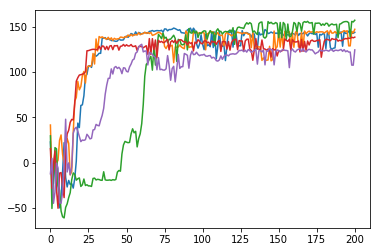

In [121]:
algorithm = SPG
recent = False
memory = True

all_output_rewards = []
for seed in seeds:
    env = RacingEnv(seed)
    alg = algorithm()
    if recent and memory:
        alg.minibatch_size = 100
    else:
        alg.minibatch_size = 200

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    try:
        run_session(output = True, episodes = 200, render = False, print_every = 10, recent = recent, memory = memory)
        #execute_env(True)
        #execute_env(True)
        #execute_env(True)
        #execute_env(True)
        #execute_env(True)
    finally:
        env.close()
        sess.close()

In [132]:
#perf_ppo_recent = all_output_rewards

#perf_ppo_log_recent = all_output_rewards
#perf_ppo_log_memory = all_output_rewards

#perf_spg_recent = all_output_rewards
#perf_spg_memory = all_output_rewards
#perf_spg_both = all_output_rewards

#perf_spg_slow_recent = all_output_rewards
#perf_spg_slow_memory = all_output_rewards
#perf_spg_slow_both = all_output_rewards

#perf_spg_unprioritized_recent = all_output_rewards
#perf_spg_unprioritized_memory = all_output_rewards
#perf_spg_unprioritized_both = all_output_rewards
#perf_spg_unprioritized_slow_recent = all_output_rewards
#perf_spg_unprioritized_slow_memory = all_output_rewards
#perf_spg_unprioritized_slow_both = all_output_rewards

In [133]:
# Save data
import pickle
data = (seeds, perf_ppo_recent, perf_spg_recent, perf_spg_both, perf_spg_memory, perf_spg_slow_recent, perf_spg_slow_memory, perf_spg_slow_both, perf_ppo_log_recent, perf_ppo_log_memory, perf_spg_unprioritized_recent, perf_spg_unprioritized_memory, perf_spg_unprioritized_both, perf_spg_unprioritized_slow_recent, perf_spg_unprioritized_slow_memory, perf_spg_unprioritized_slow_both)
with open("perfs", "wb") as f:
    pickle.dump(data, f)

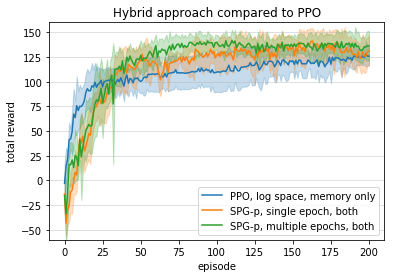

In [149]:
plot(perf_ppo_log_memory, "PPO, log space, memory only")
plot(perf_spg_both, "SPG-p, single epoch, both")
plot(perf_spg_slow_both, "SPG-p, multiple epochs, both")
plt.title("Hybrid approach compared to PPO")
plt.grid(which = "major", axis = "y", alpha = 0.5)
plt.xlabel("episode")
plt.ylabel("total reward")
plt.ylim(-60, 160)
plt.legend()

In [151]:
import scipy

def print_final_perf(perf):
    final = np.array(perf)[:,-20:]
    avgs = np.mean(final, axis = 1)
    #print(avgs)
    print("${:>.1f} \pm {:>.1f}$".format(np.mean(final), scipy.stats.sem(avgs)))

print_final_perf(perf_ppo_recent)
print_final_perf(perf_ppo_log_recent)
print_final_perf(perf_ppo_log_memory)
print_final_perf(perf_spg_recent)
print_final_perf(perf_spg_memory)
print_final_perf(perf_spg_both)
print_final_perf(perf_spg_slow_recent)
print_final_perf(perf_spg_slow_memory)
print_final_perf(perf_spg_slow_both)
print_final_perf(perf_spg_unprioritized_recent)
print_final_perf(perf_spg_unprioritized_memory)
print_final_perf(perf_spg_unprioritized_both)
print_final_perf(perf_spg_unprioritized_slow_recent)
print_final_perf(perf_spg_unprioritized_slow_memory)
print_final_perf(perf_spg_unprioritized_slow_both)

$121.5 \pm 5.8$
$119.5 \pm 4.6$
$124.2 \pm 4.9$
$101.2 \pm 2.6$
$130.6 \pm 5.2$
$129.1 \pm 6.9$
$95.8 \pm 4.7$
$141.1 \pm 5.7$
$135.9 \pm 6.2$
$94.4 \pm 3.8$
$133.5 \pm 5.7$
$132.1 \pm 6.7$
$91.9 \pm 7.5$
$138.2 \pm 4.9$
$140.9 \pm 4.0$
